In [1]:
import numpy as np
import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torch.utils.data as datatorch
import torch.nn as nn
import pandas as pd
import torch
from PIL import Image
import cv2
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from training_split import split_training
import time
import datetime

In [2]:
train_triplets = np.loadtxt('train_triplets.txt', dtype= 'str')
#train_triplets, val_triplets, _unused = split_training()
test_triplets = np.loadtxt('test_triplets.txt', dtype= 'str')

In [3]:
print(train_triplets.shape)
train_triplets, val_triplets = train_test_split(train_triplets, test_size = 0.1)
print(train_triplets.shape, val_triplets.shape)
half_index = np.int64((val_triplets.shape[0]-val_triplets.shape[0]%2)/2)
print(half_index)
val_labels = np.int64(np.ones((val_triplets.shape[0],)))
print(val_labels.shape)
val_triplets[half_index:, 1], val_triplets[half_index:, 2] = val_triplets[half_index:, 2], val_triplets[half_index:, 1].copy()
val_labels[half_index:] = np.int64(0)

(59515, 3)
(53563, 3) (5952, 3)
2976
(5952,)


In [4]:
print(test_triplets.shape)

(59544, 3)


print(train_triplets.shape)
#print()
train_triplets , val_triplets = train_test_split(train_triplets, test_size = 0.1)
print(train_triplets.shape, val_triplets.shape)
half_index = np.int64((val_triplets.shape[0]-val_triplets.shape[0]%2)/2)
print(half_index)
val_labels = np.int64(np.ones((val_triplets.shape[0],)))
print(val_labels.shape)
val_triplets[half_index:, 0], val_triplets[half_index:, 1] = val_triplets[half_index:, 1], val_triplets[half_index:, 0].copy()
val_labels[half_index:] = np.int64(0)

In [5]:
train_dir = 'food/food'
train_files = os.listdir(train_dir)
test_files = os.listdir(train_dir)


class ImageTriplesSet(Dataset):
    def __init__(self , file_array, dir, mode='train', transform = None,labels =None):
        self.triple_list = list(map(tuple, file_array))
        self.mode = mode
        self.labels = labels
        self.dir = dir
        self.transform = transform
        
    def __len__(self):
        return len(self.triple_list)
    
    def __getitem__(self,idx):
        img1 = Image.open(os.path.join(self.dir, self.triple_list[idx][0] + '.jpg'))
        img2 = Image.open(os.path.join(self.dir, self.triple_list[idx][1] + '.jpg'))
        img3 = Image.open(os.path.join(self.dir, self.triple_list[idx][2] + '.jpg'))
        
        
        if self.transform is not None:
            img1 = self.transform(img1).numpy()
            img2 = self.transform(img2).numpy()
            img3 = self.transform(img3).numpy()
        if self.labels is None:
            return img1, img2, img3
        else:
            return img1, img2, img3, self.labels[idx]
            
        #concat_img = cv2.hconcat([img1, img2, img3]).astype('float32')
        #if self.mode == 'train':
            #label = self.labels[idx]
            #return concat_img , label
            
        #else:
            #return concat_img, int(self.triple_list[idx][:-4])
        
#data_transform = transforms.Compose([
  #  transforms.Resize(350,240),
  #  transforms.CenterCrop(240),
  #  transforms.ToTensor()
#])

data_transform = transforms.Compose([
        transforms.Resize(330),
        transforms.CenterCrop(300),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = ImageTriplesSet(train_triplets, train_dir, transform = data_transform, labels = None)
val_dataset = ImageTriplesSet(val_triplets, train_dir, transform= data_transform, labels = None)
test_dataset = ImageTriplesSet(test_triplets, train_dir, mode="test" ,transform = data_transform,labels = None)

model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,5)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(2,2))
)

In [6]:
#model = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)

In [7]:
learning_rate = 0.5
batch_size = 8
epochs = 3
logstep = int(10000 // batch_size)

train_loader = datatorch.DataLoader(dataset=train_dataset, shuffle=False, batch_size=batch_size)


model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,5)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2,2)),
            torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(2,2)),
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9,weight_decay=1e-5,nesterov=True)

training_loss_vec = []
training_accuracy_vec = []
val_f1_score = []

start = time.time()
# loop over epochs
model.train()
for e in range(epochs):
    training_loss = 0.
    training_accuracy = 0.
    for idx, (data1, data2, data3) in enumerate(train_loader):
        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        embedded_a, embedded_p, embedded_n = model(data1), model(data2), model(data3)
        loss = criterion(embedded_a, embedded_p, embedded_n)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        break
        if (idx+1) % logstep == 0: 
            training_loss_vec.append(training_loss/logstep)
            print('[%d, %5d] training loss: %.5f' %
                  (e + 1, idx + 1, training_loss/logstep))
            training_loss, training_accuracy = 0.,0.
            break 
end = time.time()
print(str(datetime.timedelta(seconds= end - start)))

0:00:01.466628


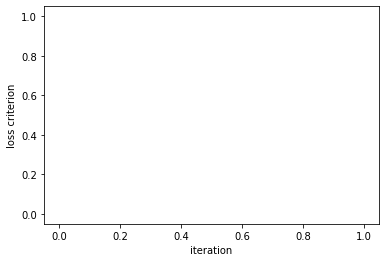

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(logstep*np.arange(1,1+len(training_loss_vec)),np.array(training_loss_vec))
plt.ylabel("loss criterion")
plt.xlabel("iteration")
plt.show()

In [9]:
learning_rate = 0.5
epochs = 3
train_loader = datatorch.DataLoader(dataset=train_dataset, shuffle=False, batch_size=8)

model2 = torch.nn.Sequential(nn.Flatten(),
            nn.Linear(147968,2048),
            )
   

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 =model2.to(device)
#create optimizer
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(),lr=learning_rate,momentum=0.9,weight_decay=1e-5,nesterov=True)

training_loss_vec = []
training_accuracy_vec = []
val_loss_vec = []
val_f1_score = []
    

start = time.time()
model.eval()
for e in range(epochs):
    training_loss = 0.
    training_accuracy = 0.
    
    model2.train()
    for idx, (data1, data2, data3) in enumerate(train_loader):
        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        embedded_a, embedded_p, embedded_n = model(data1), model(data2), model(data3)
        
        print(embedded_a.size())
        
        #feat_a = F.pairwise_distance(embedded_a, embedded_n, 2).cuda()
        #feat_b = F.pairwise_distance(embedded_a, embedded_p, 2).cuda()
        feat_a = embedded_n.cuda()
        feat_b = embedded_p.cuda()
        
        #target = torch.FloatTensor(dist_a.size()).fill_(1)
        dist_n , dist_p = model2(feat_a), model(feat_b)
        print(dist_n.size())
        break
        print(y_pred.size())
        loss = criterion2(y_pred,target) 
        # call optimizer.zero_grad()
        optimizer2.zero_grad()
        # run backward method
        loss.backward()
        # run optimizer step
        optimizer2.step()
        training_loss += loss.item()
        y_pred_idx = torch.max(y_pred.detach().cpu(),dim=1)[1]
        training_accuracy += torch.mean((y_pred_idx == target.cpu()).float()).item()
        break
        if (n+1) % logstep == 0: 
            training_loss_vec.append(training_loss/logstep)
            training_accuracy_vec.append(training_accuracy/logstep)
            print('training loss: ', training_loss/logstep,'traing_acc: ',training_accuracy/logstep)
            training_loss, training_accuracy = 0.,0.
            
    val_labels_pred = []
    model2.eval()
    for idx, (data1, data2, data3) in enumerate(val_loader):
        data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
        embedded_a, embedded_p, embedded_n = model(data1), model(data2), model(data3)

        dist_a = torch.dist(embedded_a, embedded_n, 2).cuda()
        dist_b = torch.dist(embedded_a, embedded_p, 2).cuda()
        feat = torch.cat((dist_a, dist_b), 0)
        output = model2(feat)
        pred = torch.argmax(output, dim=1)
        val_labels_pred += pred

    f1 = f1_score(val_labels_pred, val_labels)
    acc = accuracy_score(val_labels_pred, val_labels)
    val_f1_score.append(f1)
    print('Epoch :',e,' Current Validation F1 Score: ', f1, 'Current Val Acc:', acc)
    
    

end = time.time()
print(str(datetime.timedelta(seconds= end - start)))
    

torch.Size([8, 128, 34, 34])


RuntimeError: Given groups=1, weight of size 64 3 5 5, expected input[8, 128, 34, 34] to have 3 channels, but got 128 channels instead

In [ ]:
print(len(val_labels_pred,))

In [ ]:
test_loader = datatorch.DataLoader(dataset=test_dataset, shuffle = False, batch_size= 8)

In [ ]:
test_triplets_pred = []
model.eval()
model2.eval()
for idx, (data1, data2, data3) in enumerate(test_loader):
    data1, data2, data3 = data1.cuda(), data2.cuda(), data3.cuda()
    embedded_a, embedded_p, embedded_n = model(data1), model(data2), model(data3)
    dist_a = torch.dist(embedded_a, embedded_n, 2)
    dist_b = torch.dist(embedded_a, embedded_p, 2)
    feat = torch.cat((dist_a, dist_b), 0).cuda()
    output = model2(feat)
    pred = torch.argmax(output, dim=1)
    test_triplets_pred += pred
    

In [ ]:
print(len(test_triplets_pred))

In [ ]:
with open('submission2_Ketzel.txt', 'w') as f:
    for item in test_triplets_pred:
        f.write(str(item) + '\n')